Consignas del tp3:


2. Resuelva (aproximadamente) el “Traveling salesman problem” para 200 ciudades con
una red de Kohonen.



vamos con el ej 2. Lo primero es generar un dataset de ciudades.

Tomé un dataset de 312 ciudades estadounidenses, tal vez eso deje graficarlo bien en un mapa para que se vea a ojo si es óptimo. igual vamos a ir armando dataset incrementalmente más dificiles de resolver. 

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [131]:
dataset = np.loadtxt('C:/Users/ignac/Documents/GitHub/Redes-neuronales/tp3/us_cities_312.csv', delimiter=',',dtype=str)

coords = dataset[1:,2:4].astype(float)
city = dataset[1:,0]
states = dataset[1:,1]

In [132]:
# armo otros datasets más chicos

coords_20 = coords[:20]
city_20 = city[:20]
states_20 = states[:20]

coords_50 = coords[:50]
city_50 = city[:50]
states_50 = states[:50]

coords_100 = coords[:100]
city_100 = city[:100]
states_100 = states[:100]

coords_200 = coords[:200]
city_200 = city[:200]
states_200 = states[:200]

# Dataset de 20 ciudades
dataset_20 = {
    "coords": coords[:20],
    "city": city[:20],
    "states": states[:20]
}

# Dataset de 50 ciudades
dataset_50 = {
    "coords": coords[:50],
    "city": city[:50],
    "states": states[:50]
}

# Dataset de 100 ciudades
dataset_100 = {
    "coords": coords[:100],
    "city": city[:100],
    "states": states[:100]
}

# Dataset de 200 ciudades
dataset_200 = {
    "coords": coords[:200],
    "city": city[:200],
    "states": states[:200]
}

# Dataset de 312 ciudades (completo)
dataset_312 = {
    "coords": coords[:312],  # o simplemente coords
    "city": city[:312],
    "states": states[:312]
}


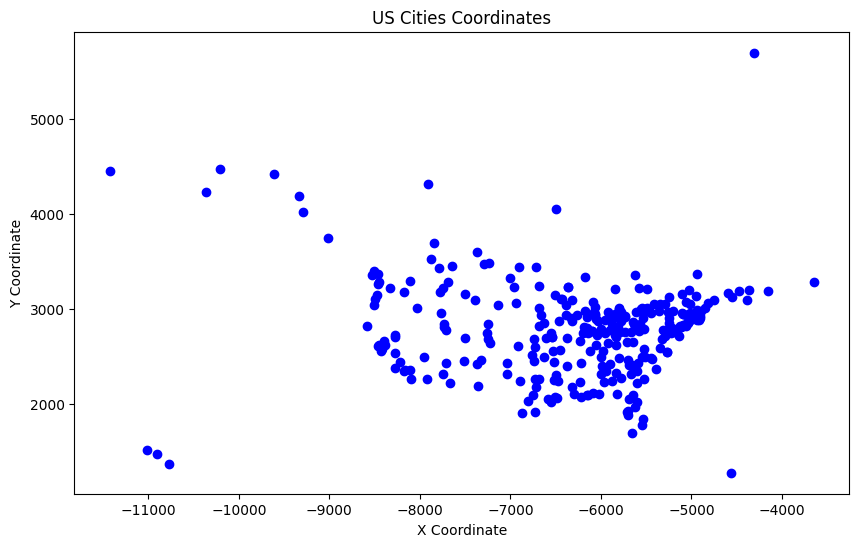

In [133]:
plt.figure(figsize=(10,6))
plt.scatter(coords[:,0], coords[:,1], color='blue')
plt.title('US Cities Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [134]:
# Extraer X e Y
x = coords[:, 0]
y = coords[:, 1]

# === GRAFICO INTERACTIVO SOLO DE CIUDADES ===
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode="markers",
    marker=dict(size=6),
    text=[f"{city[i]} ({states[i]})" for i in range(len(city))],
    hovertemplate="<b>%{text}</b><br>X: %{x}<br>Y: %{y}<extra></extra>"
))

fig.update_layout(
    title="Mapa de Ciudades (coordenadas X,Y)",
    xaxis_title="X",
    yaxis_title="Y",
    width=900,
    height=700
)

fig.show()

In [ ]:
class red_kohonen:
    def __init__(self, n_neuronas_x=1, n_neuronas_y=1, tasa_aprendizaje_inicial=0.1, n_iteraciones=100):
        """
        La idea es que admita datos de cualquier tipo pero los baja a 2D. 
        Los datos deben ser pasados en un array numpy de shape (n_muestras, n_features).
        Luego, la red de Kohonen tendrá una grilla de neuronas de tamaño (n_neuronas_x, n_neuronas_y).
        Y un vector de pesos en cada celda de la grilla, de tamaño (n_features,).
        Parámetros:
        - n_neuronas_x: número de neuronas en la dimensión x de la grilla
        - n_neuronas_y: número de neuronas en la dimensión y de la grilla
        - tasa_aprendizaje_inicial: tasa de aprendizaje inicial
        - n_iteraciones: número de iteraciones para el entrenamiento
        
        """
        self.n_neuronas_x = n_neuronas_x
        self.n_neuronas_y = n_neuronas_y
        self.tasa_aprendizaje_inicial = tasa_aprendizaje_inicial
        self.n_iteraciones = n_iteraciones
        self.matriz_neuronas = np.zeros((n_neuronas_x, n_neuronas_y, 2))
        
        # Pre-calcular grilla de coordenadas para las neuronas
        self.grid_x, self.grid_y = np.meshgrid(np.arange(n_neuronas_x), np.arange(n_neuronas_y), indexing='ij')



    def initialize_neurons(self, data):
        """cambiado para que no falle cuando n_neuronas_x * n_neuronas_y > n_muestras
        Inicializa las neuronas en una configuración circular alrededor del centro de los datos.
        parecería ser practica común en TSP."""
        N = self.n_neuronas_x
        t = np.linspace(0, 2*np.pi, N, endpoint=False)

        cx = np.mean(data[:,0])
        cy = np.mean(data[:,1])
        sx = (np.max(data[:,0]) - np.min(data[:,0])) / 2
        sy = (np.max(data[:,1]) - np.min(data[:,1])) / 2

        x = cx + sx * np.cos(t)
        y = cy + sy * np.sin(t)

        self.matriz_neuronas = np.vstack([x,y]).T.reshape(N,1,2)
     # esto crea topologias de anillo especificamente para este ejercicio! e inicializa con circulos

    def entrenar(self, data, varianza_vecindad=1.0):
        """
        Entrena la red de Kohonen con vectorización (mucho más rápido).
        """
        self.initialize_neurons(data)
        n_muestras = data.shape[0]
        
        for iteracion in range(self.n_iteraciones):
            tasa_aprendizaje = self.tasa_aprendizaje_inicial
            varianza_actual = varianza_vecindad * (1 - iteracion / self.n_iteraciones)
            
            # Barajamos los índices de las muestras
            indices = np.random.permutation(n_muestras)
            
            for i in indices:
                muestra = data[i]
                
                # Encontrar la neurona ganadora (BMU) - vectorizado
                distancias = np.linalg.norm(self.matriz_neuronas - muestra, axis=2)
                bmu_index = np.unravel_index(np.argmin(distancias), distancias.shape)
                
                # Calcular distancias en la grilla de forma vectorizada pero con wrapping para este problema
                N = self.n_neuronas_x
                idxs = np.arange(N)

                dist_lineal = np.abs(idxs - bmu_index[0])
                dist_circular = np.minimum(dist_lineal, N - dist_lineal)

                distancias_grilla = dist_circular.reshape(N,1)
                                
                # Función de vecindad gaussiana vectorizada
                h_ij = np.exp(-distancias_grilla**2 / (2 * varianza_actual**2))
                
                # Actualizar todos los pesos a la vez
                delta = tasa_aprendizaje * h_ij[..., np.newaxis] * (muestra - self.matriz_neuronas)
                self.matriz_neuronas += delta

"""
Los cambios principales son:

Pre-calcular la grilla de coordenadas (meshgrid) en el __init__ para evitar recalcularla cada iteración

Vectorizar el cálculo de distancias en la grilla usando NumPy arrays en lugar de bucles

Función gaussiana vectorizada calculada de una sola vez para todas las neuronas

Actualización vectorizada de todos los pesos con broadcasting: h_ij[..., np.newaxis] expande la dimensión para multiplicar correctamente

Shuffle de muestras para mejor convergencia estocástica

"""

'\nLos cambios principales son:\n\nPre-calcular la grilla de coordenadas (meshgrid) en el __init__ para evitar recalcularla cada iteración\n\nVectorizar el cálculo de distancias en la grilla usando NumPy arrays en lugar de bucles\n\nFunción gaussiana vectorizada calculada de una sola vez para todas las neuronas\n\nActualización vectorizada de todos los pesos con broadcasting: h_ij[..., np.newaxis] expande la dimensión para multiplicar correctamente\n\nShuffle de muestras para mejor convergencia estocástica\n\n'

Mi approach es simple: darle buena varianza porque las ciudades están muy separadas entre sí. Por ahora voy a estimar a ojo la variaza con el dataset más chivo y vemos como mantiene. voy a usar una matriz de neuronas 1D con tantas neuronas como datos pero ajustando para lograr el mejor fit. 

In [136]:
def entrenar_1D_unico(dataset, alpha=0.1, iteraciones=1000, varianza=3, multiplicador=2):

    coords = dataset["coords"]
    N = len(coords)

    n_neuronas = int(N * multiplicador)

    red = red_kohonen(
        n_neuronas_x=n_neuronas,
        n_neuronas_y=1,
        tasa_aprendizaje_inicial=alpha,
        n_iteraciones=iteraciones
    )

    red.entrenar(coords, varianza_vecindad=varianza)

    visualizar_kohonen_1D(red, coords, titulo=f"Kohonen 1D {N} ciudades")

    return red


def visualizar_kohonen_1D(red, data, titulo="Red Kohonen 1D"):

    pesos = red.matriz_neuronas  # (N, 1, 2)
    N = red.n_neuronas_x

    pesos_flat = pesos.reshape(-1, 2)

    fig = go.Figure()

    # Datos
    fig.add_trace(go.Scatter(
        x=data[:, 0],
        y=data[:, 1],
        mode="markers",
        marker=dict(size=5, color="blue"),
        name="Datos"
    ))

    # Neuronas
    fig.add_trace(go.Scatter(
        x=pesos_flat[:, 0],
        y=pesos_flat[:, 1],
        mode="markers",
        marker=dict(size=10, symbol="square", color="red"),
        name="Neuronas"
    ))

    # Conexiones (cadena lineal)
    for i in range(N - 1):
        fig.add_trace(go.Scatter(
            x=[pesos_flat[i, 0], pesos_flat[i + 1, 0]],
            y=[pesos_flat[i, 1], pesos_flat[i + 1, 1]],
            mode="lines",
            line=dict(width=1, color="gray"),
            showlegend=False
        ))

    fig.update_layout(
        title=titulo,
        width=800,
        height=700,
        xaxis_title="X",
        yaxis_title="Y",
        showlegend=True
    )
    # cerrar ciclo
    fig.add_trace(go.Scatter(
        x=[pesos_flat[-1, 0], pesos_flat[0, 0]],
        y=[pesos_flat[-1, 1], pesos_flat[0, 1]],
        mode="lines",
        line=dict(width=1, color="gray"),
        showlegend=False
    ))

    fig.show()


In [ ]:
resultados_20 = entrenar_1D_unico(
    dataset_20,
    alpha=0.5,
    iteraciones=3000,
    varianza=2,
    multiplicador=2 # doble de neuronas para que haga super overfitting, que parecería ser lo ideal para TSP
)

# overfitting hace mejores recorridos entre ciudades


In [ ]:
resultados_20 = entrenar_1D_unico(
    dataset_20,
    alpha=0.5,
    iteraciones=3000,
    varianza=2,
    multiplicador=1 # doble de neuronas para que haga super overfitting, que parecería ser lo ideal para TSP
)
# con interplocación


In [144]:
resultados_50 = entrenar_1D_unico(
    dataset_50,
    alpha=0.5,
    iteraciones=10000,
    varianza=10,
    multiplicador=2
)


In [146]:

resultados_100 = entrenar_1D_unico(
    dataset_100,
    alpha=0.5,
    iteraciones=15000,
    varianza=8,
    multiplicador=2
)

In [148]:

resultados_200 = entrenar_1D_unico(
    dataset_200,
    alpha=0.5,
    iteraciones=10000,
    varianza=8,
    multiplicador=2
)

In [149]:

resultados_312 = entrenar_1D_unico(
    dataset_312,
    alpha=0.5,
    iteraciones=10000,
    varianza=8,
    multiplicador=2
)